In [37]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
# import pandas as pd
# import numpy as np
# import os
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
# import cv2
from torchvision import transforms
from pzData import pzImg
from ezPzModels import ezPzCNN

In [38]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("cuda")
else:
    device = torch.device('cpu')
    print("CPU")

cuda


In [23]:
# class pzImageset(Dataset):
#     def __init__(self, label_file, data_dir, transform=None):
#         self.labels = pd.read_csv(label_file)
#         self.data_dir = data_dir
#         self.transform = transform
    
#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         filename = self.labels.iloc[idx]['Filename']
#         filename = os.path.join(self.data_dir, (filename[:-4] + ".png"))
#         data = cv2.imread(filename) 
#         if self.transform:
#             data = self.transform(data)
#         return np.asarray(data), self.labels.iloc[idx]['0']

In [24]:
# class ezPiezoCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(ezPiezoCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(32 * 120 * 160, 128)
#         self.fc2 = nn.Linear(128, num_classes)

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = self.pool(x)
#         x = torch.relu(self.conv2(x))
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

In [40]:
train_labels = "./data/train_labels.csv"
test_labels = "./data/test_labels.csv"
val_labels = "./data/val_labels.csv"
train_dir = test_dir = val_dir = "./data/raw/"

transform = transforms.Compose([
    # transforms.Resize((480, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = pzImg(train_labels, train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

test_dataset = pzImg(test_labels, test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=10)

val_dataset = pzImg(val_labels, val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=10)

In [41]:
# model parameters
input_size = 480*640*3
num_layers = 2
# for now, this is only a binary classification task
num_classes = 2

In [44]:
device = torch.device('cpu')
model = ezPzCNN(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

train_losses = []
val_losses = []

model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long)

        scores = model(x)
        loss = criterion(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    train_losses.append(running_loss / len(train_loader))

    model.eval()

    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.to(device=device, dtype=torch.float32)
            val_y = val_y.to(device=device, dtype=torch.long)
            val_scores = model(val_x)
            _, preds = torch.max(val_scores, 1)
            val_loss = criterion(val_scores, val_y).item()
            num_correct += (preds == val_y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

        val_accuracy = accuracy_score(val_y.cpu().numpy(), preds.cpu().numpy())
        print(f'Validation Accuracy: {val_accuracy}')

        val_losses.append(val_loss / len(val_loader))

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [33]:
# best_accuracy
best_model = model

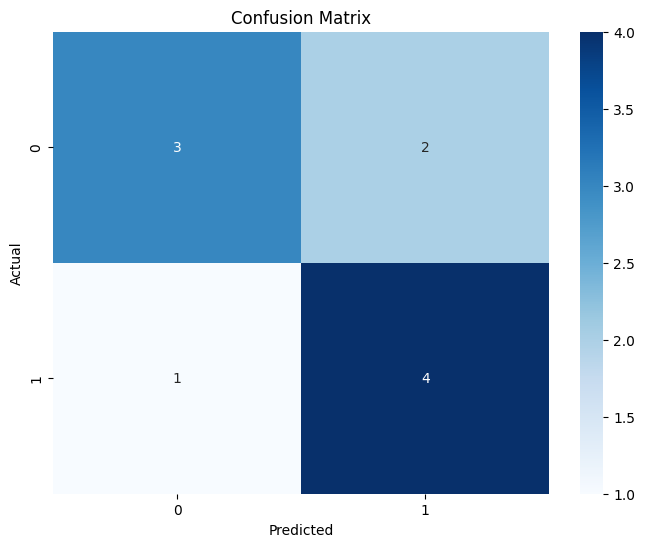

In [35]:
confusion = confusion_matrix(val_y.cpu().numpy(), preds.cpu().numpy())

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [36]:
torch.save(best_model, "bin_cnn.pth")